In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import stackstac
import planetary_computer
import numpy as np
import xarray as xr
import rioxarray as rio
import os
import pandas as pd
from pathlib import Path
from pystac_client import Client
import folium

root = Path.cwd()

In [ ]:
pts = gpd.read_file(root / 'beech_stands' / 'Points.shp' )
pts = pts.to_crs(26918)
# remove first 4 rows
pts2 = pts.loc[4:,]

# make separate species and dbh columns
pts2['species'] = [x[0] for x in pts2.Name.str.split('dbh')]
pts2['dbh'] = [x[-1] for x in pts2.Name.str.split('dbh')]
pts2 = pts2.drop('Name',axis=1)

# make separate beech and nonbeech gdf
pts2['species'] = pts2.species.str.strip()
beech_pts = pts2.loc[pts2.species=='beech']
beech_pts.shape
beech_pts['index'] = np.arange(0,len(beech_pts))

nonbeech_pts = pts2.loc[pts2.species!='beech']
nonbeech_pts.shape
nonbeech_pts = nonbeech_pts.reset_index()

In [ ]:
# Pecoy Notch Unit idx 37
# 11 nonbeech

# South roundtop unit idx 72
# 1 nonbeech

# south scribner hollow unit idx 73 (single beech)
# 2 nonbeech

# visitor center idx 96    
# 3 nonbeech trees

In [61]:
# choose point to serve as map center coordinates
map_coords = tuple(beech_pts.to_crs(4326).get_coordinates().iloc[37,]) # get xy coords for index 37
map_coords = tuple([map_coords[1],map_coords[0]]) # switch them around because everything is integrated seamlessly

# define 100m buffers for each cluster of pointss
pecoy_buffer = beech_pts.iloc[27:28,].buffer(100)
roundtop_buffer = beech_pts.iloc[54:55,].buffer(100)
visitors_buffer = beech_pts.iloc[66:67,].buffer(100)

s = pd.concat([pecoy_buffer,roundtop_buffer,visitors_buffer])

# plot results
m = folium.Map(location=map_coords, zoom_start=11)

folium.GeoJson(
    nonbeech_pts.to_crs(4326),
    marker=folium.Circle(radius=2, fill_color="orange", fill_opacity=0.4, color="black", weight=1),
    tooltip=folium.GeoJsonTooltip(fields=["index","species"])
).add_to(m)

# folium.GeoJson(
#     s.to_crs(4326)
# ).add_to(m)

m

number of low cloud images: 37


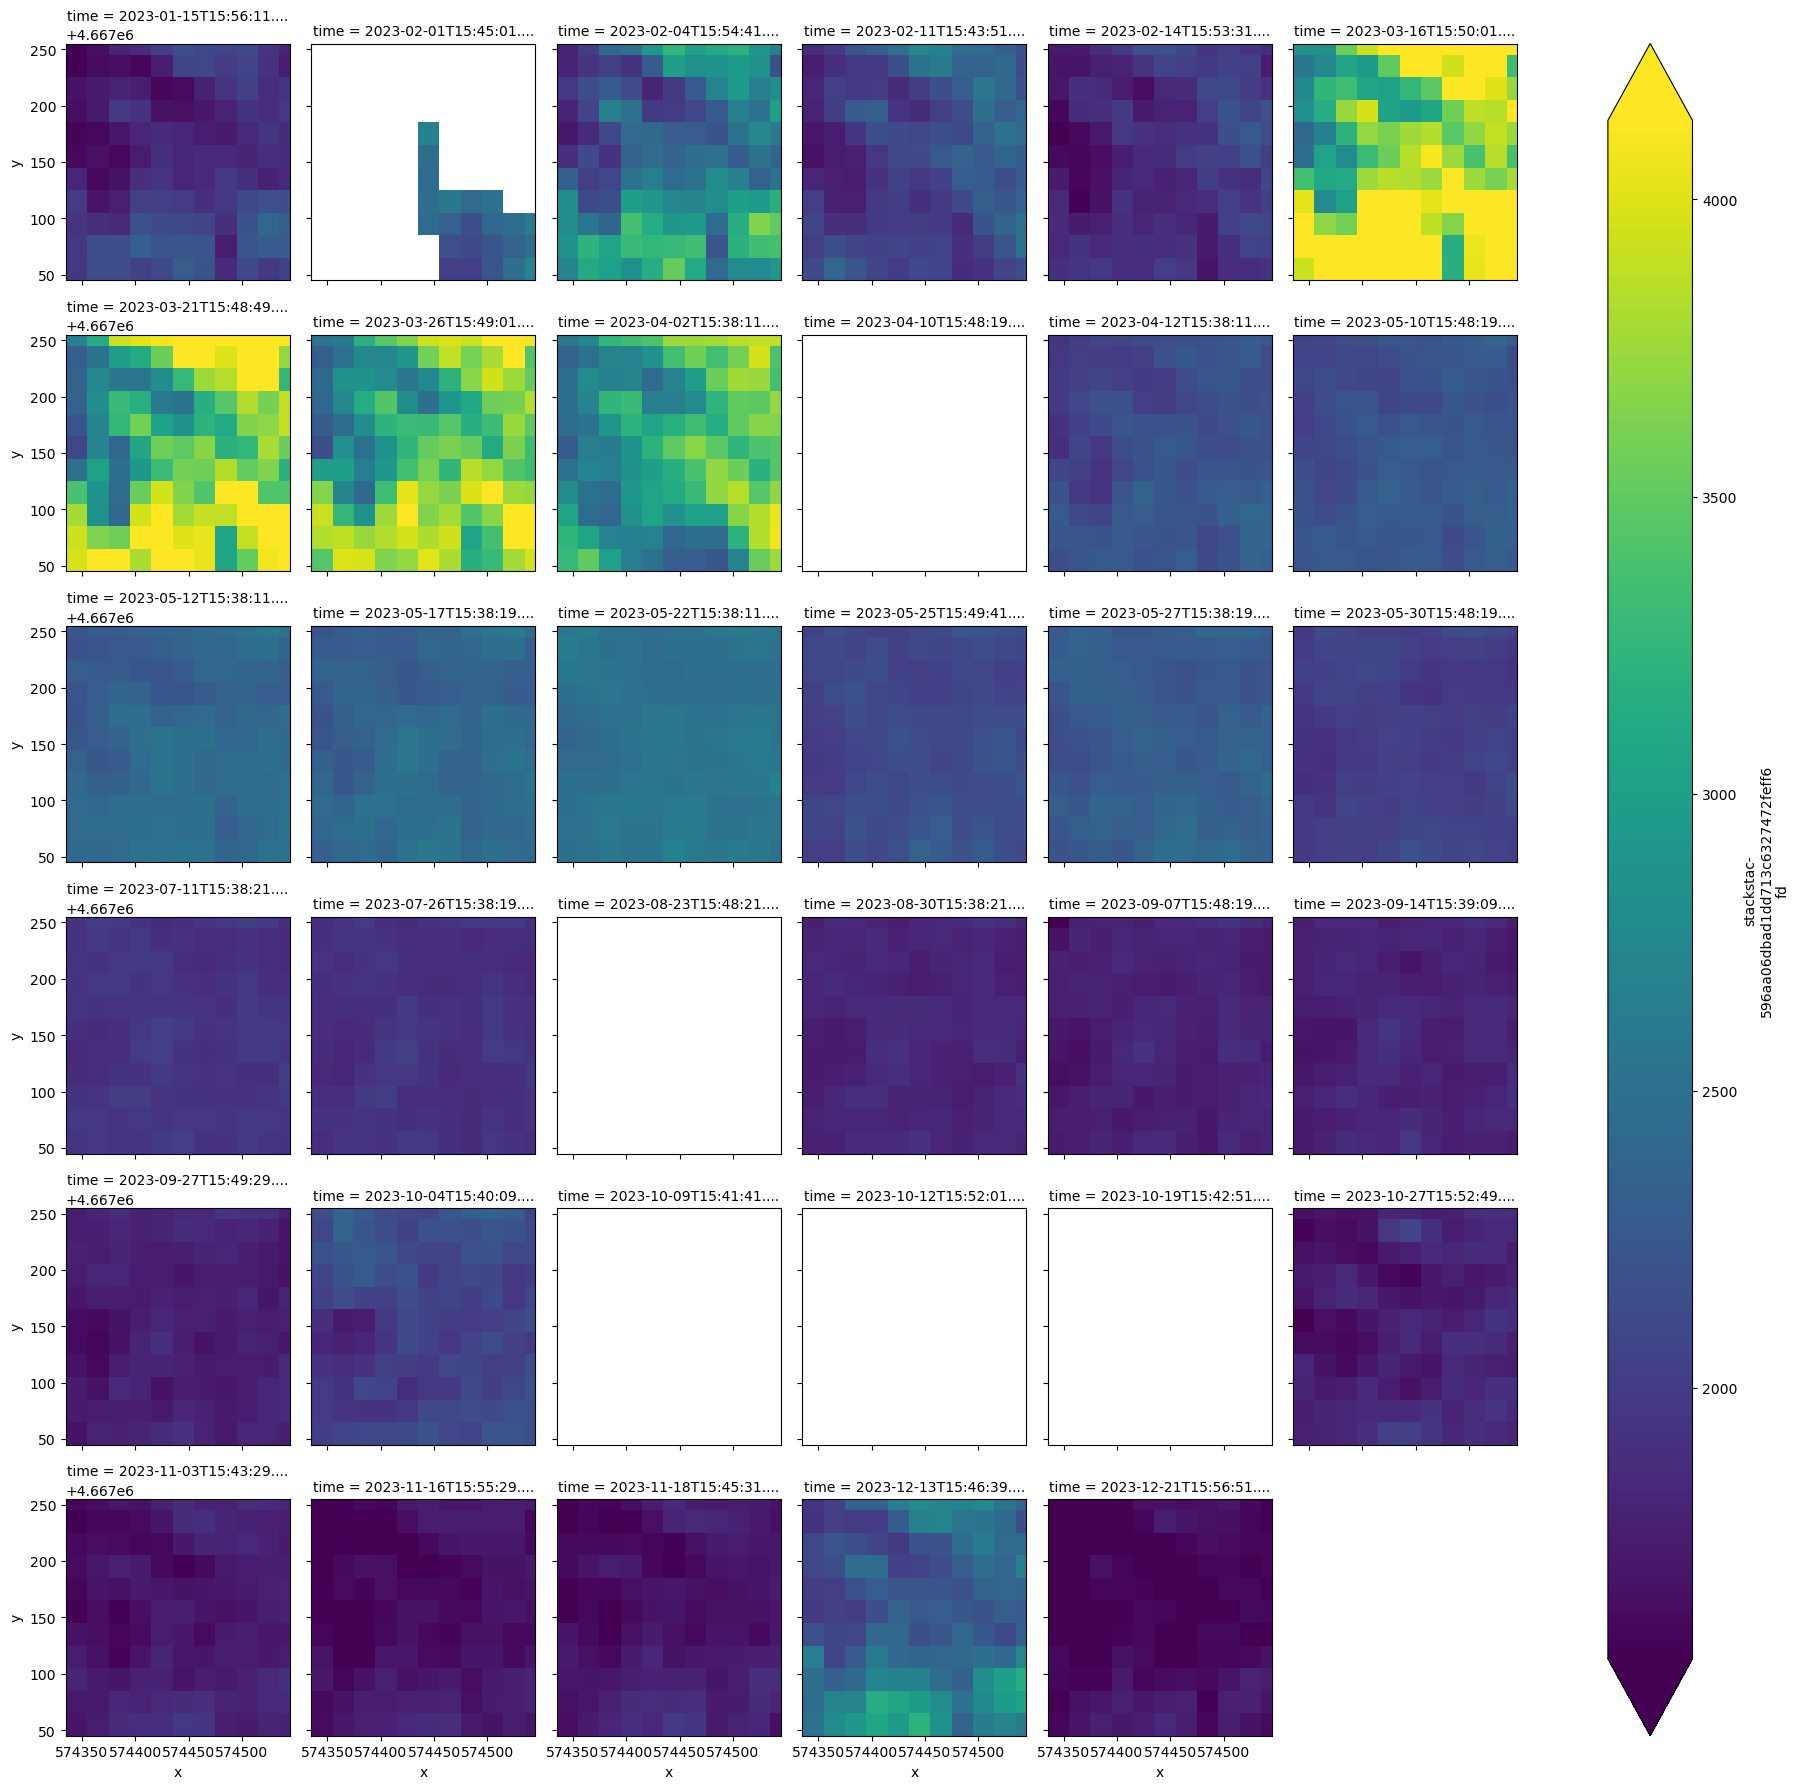

In [9]:
buff = roundtop_buffer

bbox_4326 = tuple(buff.to_crs(4326).total_bounds)
bbox_utm = tuple(buff.total_bounds)

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

items = catalog.search(
    bbox=bbox_4326,
    collections=["sentinel-2-l2a"],
    datetime="2023-01-01/2023-12-31"
).item_collection()
len(items)

# create xarray
stack = stackstac.stack(
    items,
    epsg=26918,
    resolution=10,
    bounds=bbox_utm,
    assets=['B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12','SCL']).where(lambda x: x > 0, other=np.nan)

# filter for images < 20% cloud cover
lowcloud = stack[stack["eo:cloud_cover"] < 20]
# print number of filtered images
print('number of low cloud images:',lowcloud.shape[0])

# mask based on SCL band
# 9: cloud high prob
# 8: cloud medium prob
# 3: cloud shadow
# 10: thin cirrus
scl_band = lowcloud.sel(band='SCL')
masked = lowcloud.where((scl_band != 9) & (scl_band !=3) & (scl_band !=8) & (scl_band != 10))

# drop SCL band
masked = masked.drop_sel(band='SCL')

drop_duplicates = masked.drop_duplicates(dim='time',keep='first')

drop_duplicates.isel(band=3).plot(col='time',col_wrap=6,robust=True)

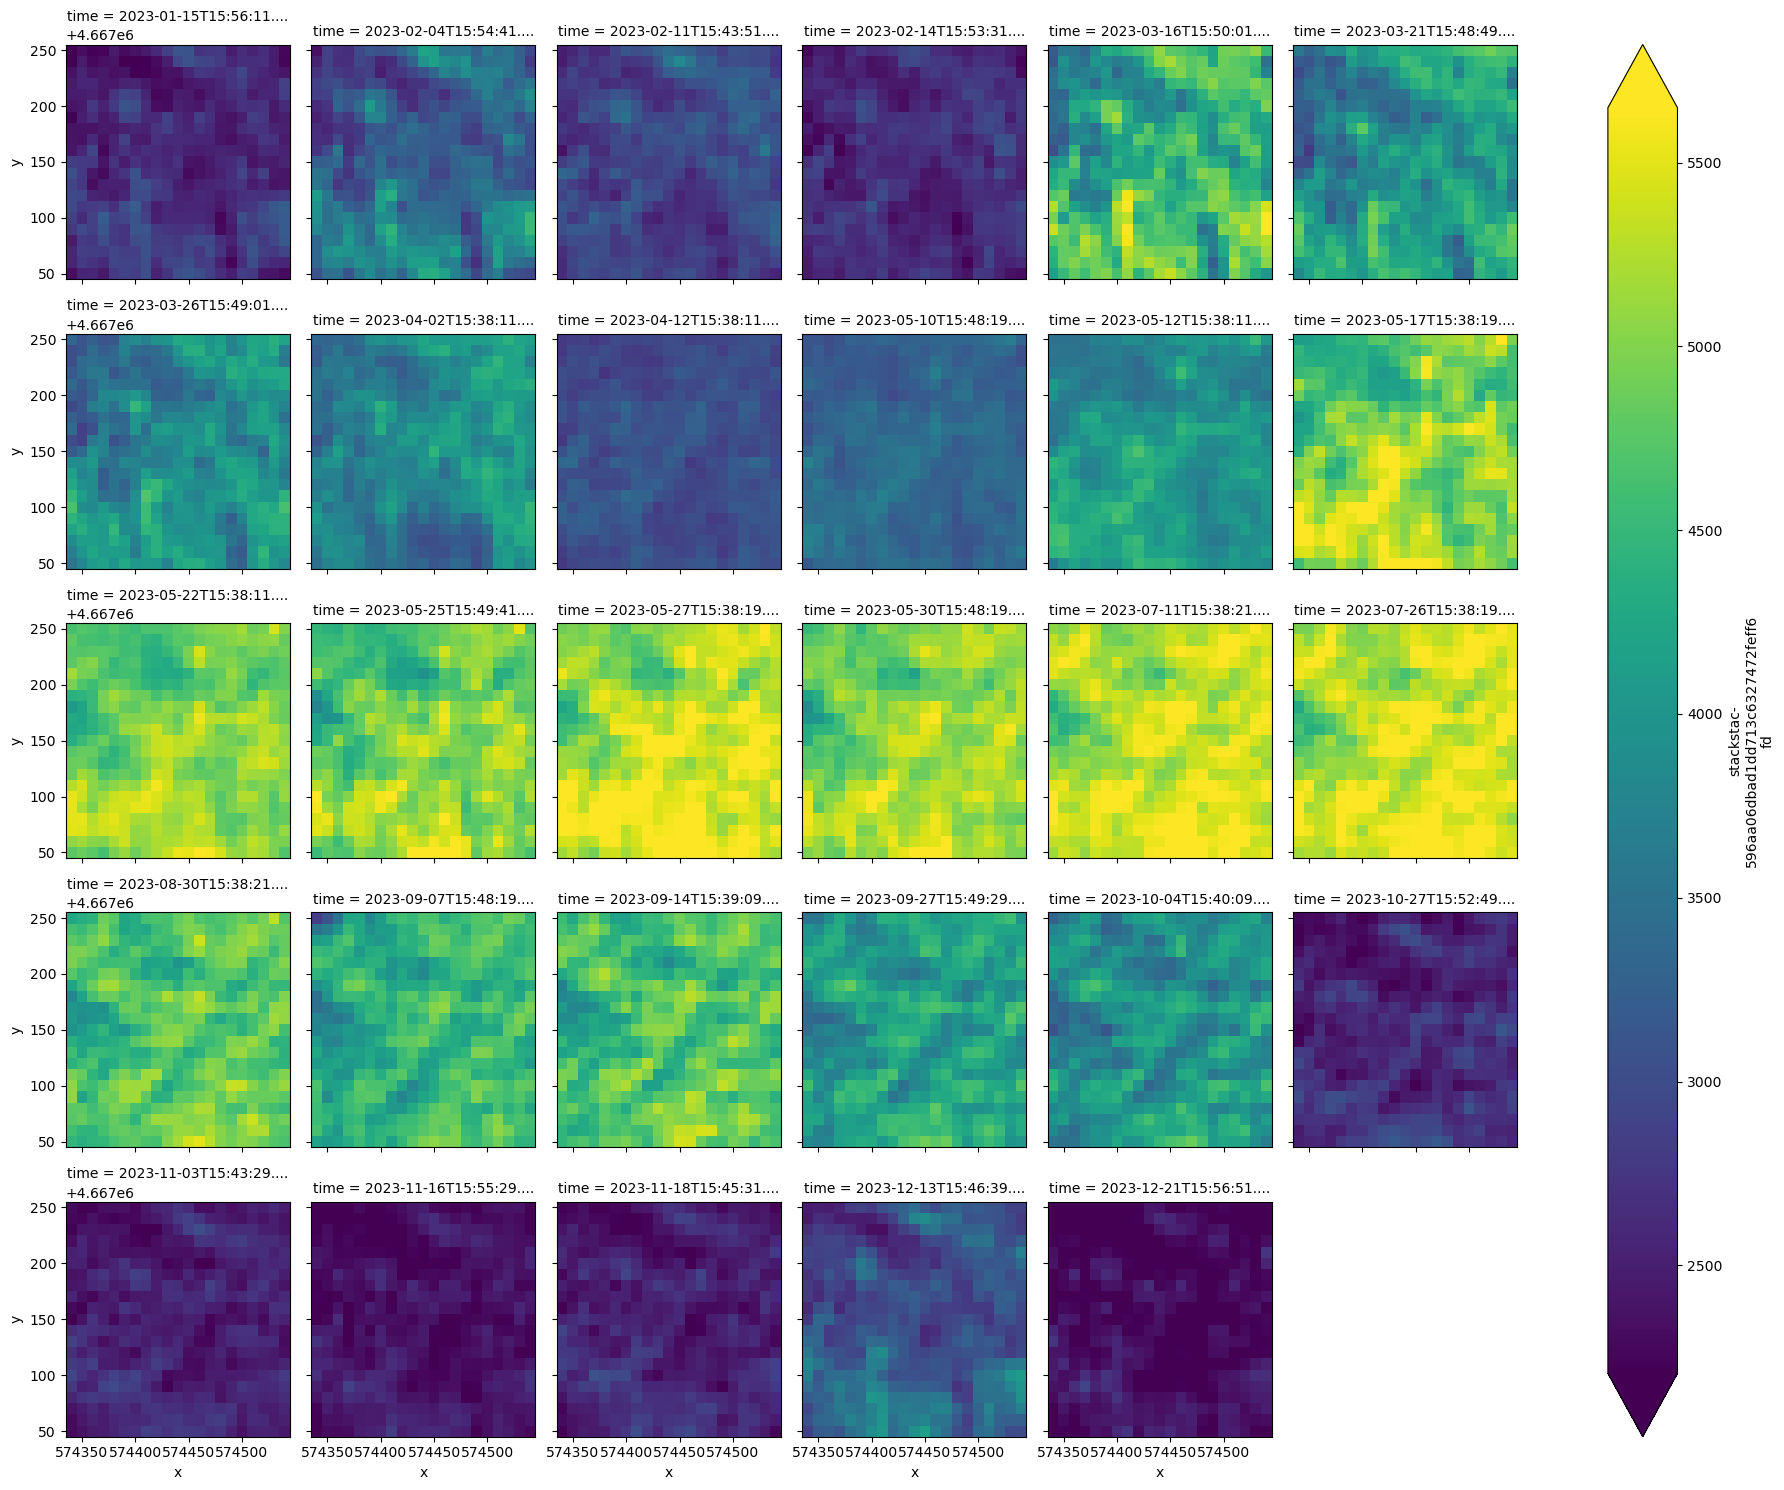

In [10]:
# manually drop times with partial data

to_drop = drop_duplicates.time.values[[1,9,20,26,27,28]]
drop_partial = drop_duplicates.drop_sel({'time':to_drop})

drop_partial.isel(band=6).plot(col='time',col_wrap=6,robust=True)

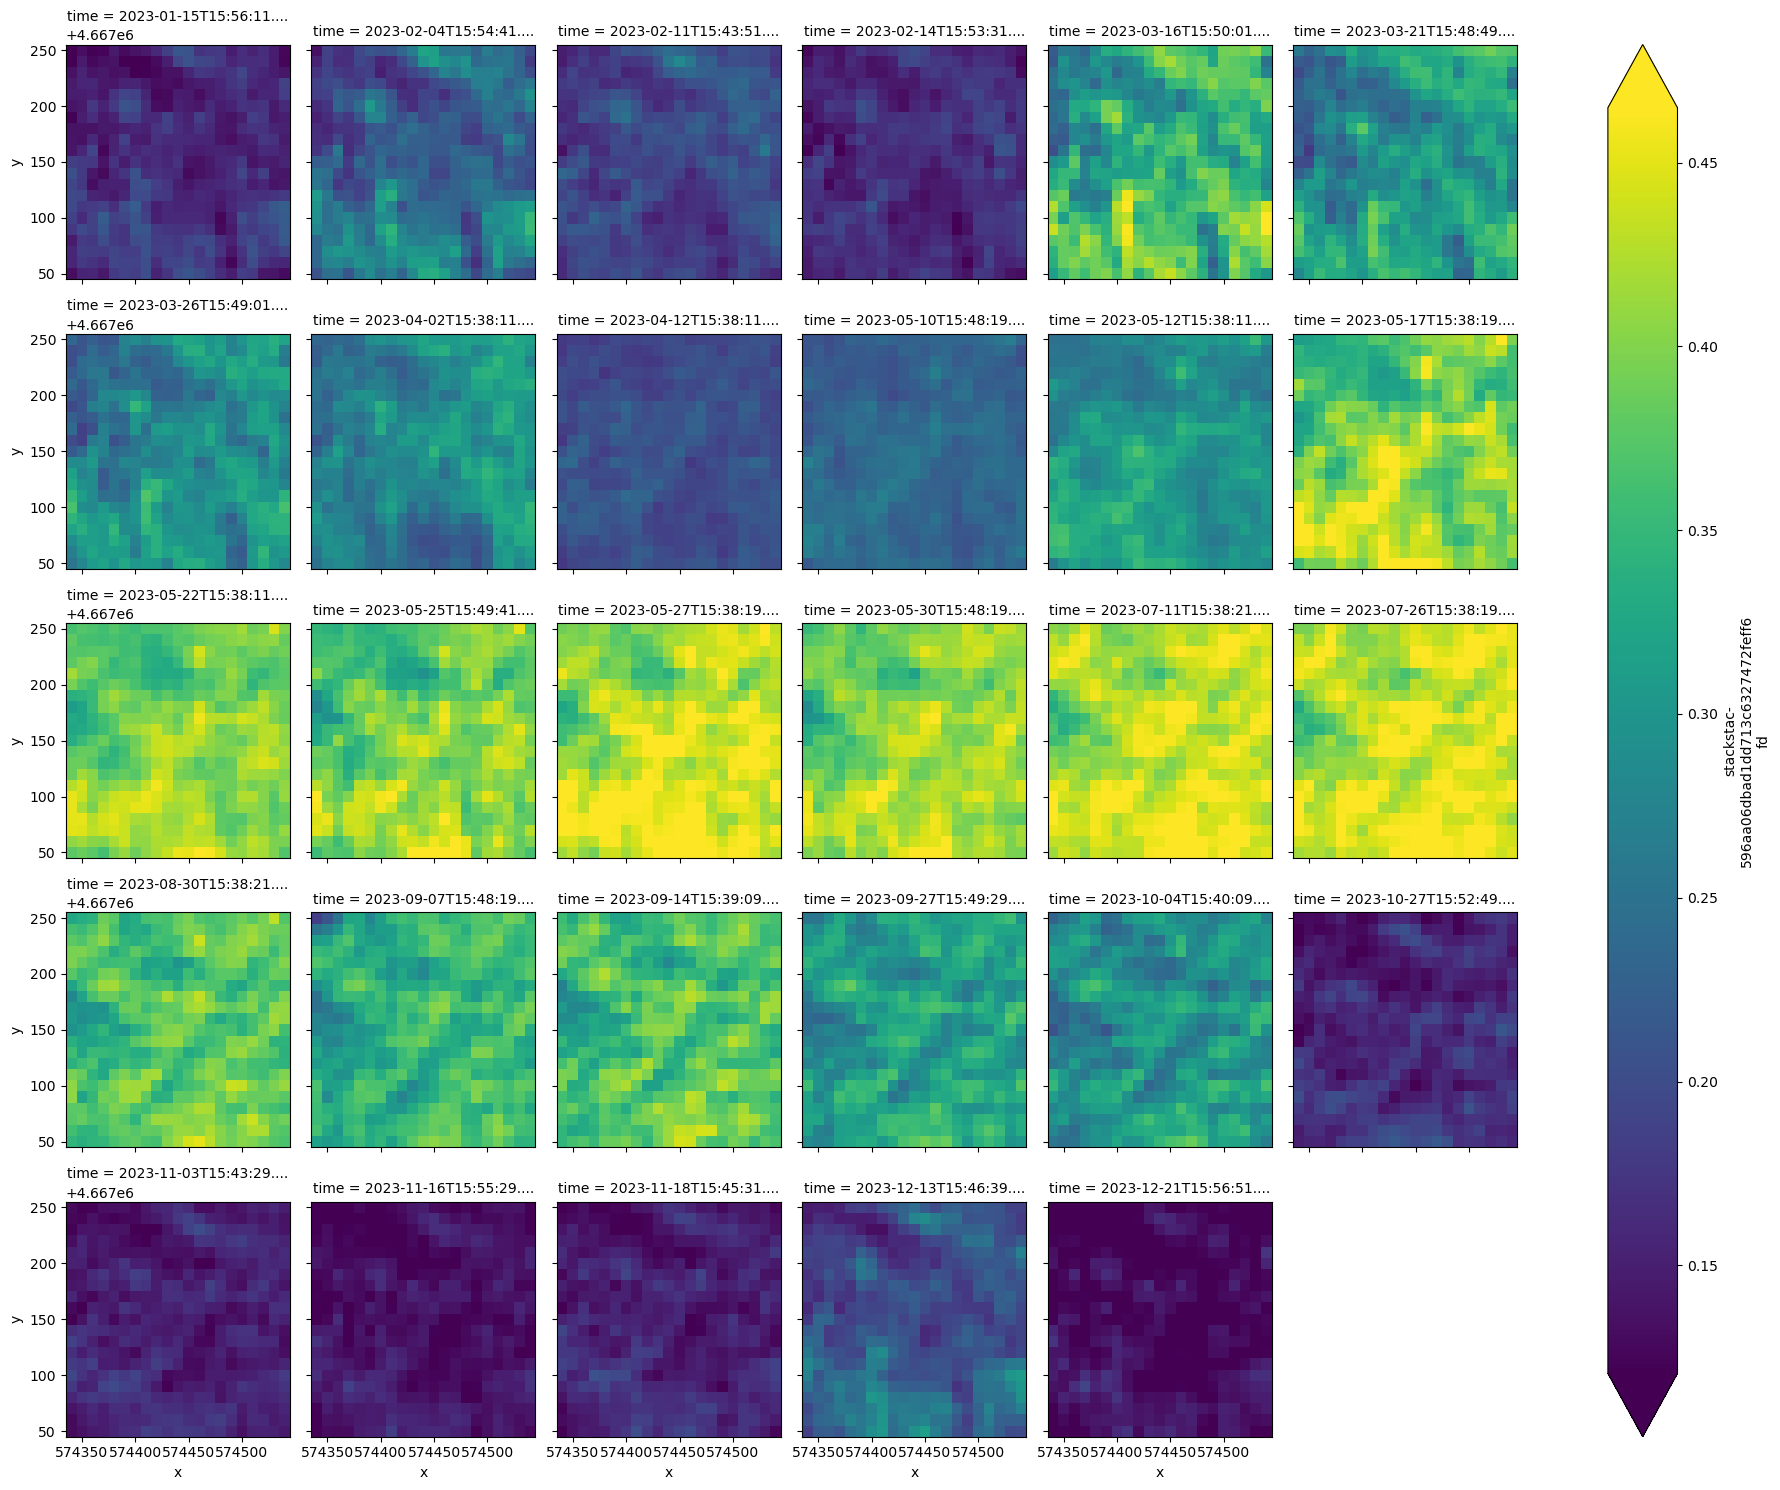

In [11]:
scaled = (drop_partial - 1000) / 10000

scaled.isel(band=6).plot(col='time',col_wrap=6,robust=True)

In [12]:
filename = '2023_roundtop'

scaled = scaled.reset_coords(drop=True)
scaled.to_netcdf(root / 'sentinel_data' / f'{filename}.nc')

In [ ]:
# select trees within roundtop buffer
points_idx = roundtop_buffer.sindex.query(beech_pts.geometry, predicate="intersects")[0]
roundtop_trees = beech_pts.iloc[points_idx]


C:\Users\roseh\AppData\Local\Temp\ipykernel_21644\1084164894.py:5: UserWarning: The indices of the left and right GeoSeries' are not equal, and therefore they will be aligned (reordering and/or introducing missing values) before executing the operation. If this alignment is the desired behaviour, you can silence this warning by passing 'align=True'. If you don't want alignment and protect yourself of accidentally aligning, you can pass 'align=False'.
  p = beech_pts.within(roundtop_buffer)


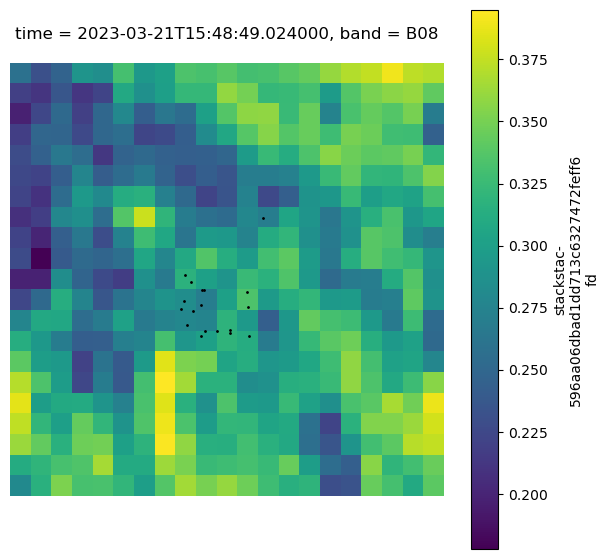

In [ ]:
# plot trees overlaid with sentinel data
fig, ax = plt.subplots(ncols=1, figsize=(7, 7))

img = scaled.isel(band=6,time=5)
#img = xr.apply_ufunc(exposure.rescale_intensity, img)
p = beech_pts.within(roundtop_buffer)

img.plot.imshow(ax=ax)
roundtop_trees.plot(ax=ax,color='black',markersize=1)



ax.set_axis_off()